In [1]:
pip install torch pytorch-lightning pytorch_forecasting

Note: you may need to restart the kernel to use updated packages.


In [2]:
import warnings
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
import random
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf 
import tensorboard as tb 
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile


# Define the path to 'total.csv'
total_csv_path = '/kaggle/input/total-with-category/total_with_category.csv'

# Load 'total.csv' and set index to 'date'
#data = pd.read_csv(total_csv_path, parse_dates=['date'], index_col='date')
data = pd.read_csv(total_csv_path)


data = data[data['store'] == 548]

# Add 'unique_id' column
data['unique_id'] = data['item_nbr'].astype(str) + '_' + data['store'].astype(str)

# Drop 'item_nbr' and 'store' columns
data.drop(['item_nbr', 'store'], axis=1, inplace=True)

# Select 1 random unique_ids and filter the data
random_unique_ids = random.sample(list(data['unique_id'].unique()), 1)
data = data[data['unique_id'].isin(random_unique_ids)]


# Sort the data by 'unique_id' and 'date'
data.sort_values(by=['unique_id', 'date'], inplace=True)

# Convert the date column to a datetime object and set it as the index
data['date'] = pd.to_datetime(data['date'])


# Add lags for the past 14 days
for i in range(1, 15):
    data[f'unit_sales_lag_{i}'] = data.groupby('unique_id')['unit_sales'].shift(i)

data = data.dropna()

data

,unit_sales,bogo,circular_discount,circular,circedlp,coupon,discount_value,discount,fp_discount,front_page,...,unit_sales_lag_5,unit_sales_lag_6,unit_sales_lag_7,unit_sales_lag_8,unit_sales_lag_9,unit_sales_lag_10,unit_sales_lag_11,unit_sales_lag_12,unit_sales_lag_13,unit_sales_lag_14
6574293,6.0,0.0,0.0,0.0,0.0,0.0,0.1643,1.0,0.0,0.0,...,0.0,1.0,4.0,1.0,2.0,0.0,3.0,1.0,4.0,2.0
6574294,4.0,0.0,0.0,0.0,0.0,0.0,0.1643,1.0,0.0,0.0,...,2.0,0.0,1.0,4.0,1.0,2.0,0.0,3.0,1.0,4.0
6574295,1.0,0.0,0.0,0.0,0.0,0.0,0.1643,1.0,0.0,0.0,...,3.0,2.0,0.0,1.0,4.0,1.0,2.0,0.0,3.0,1.0
6574296,1.0,0.0,0.0,0.0,0.0,0.0,0.1643,1.0,0.0,0.0,...,2.0,3.0,2.0,0.0,1.0,4.0,1.0,2.0,0.0,3.0
6574297,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,...,5.0,2.0,3.0,2.0,0.0,1.0,4.0,1.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6575035,1.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,...,0.0,0.0,1.0,2.0,2.0,3.0,1.0,0.0,2.0,0.0
6575036,2.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,...,3.0,0.0,0.0,1.0,2.0,2.0,3.0,1.0,0.0,2.0
6575037,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,...,3.0,3.0,0.0,0.0,1.0,2.0,2.0,3.0,1.0,0.0
6575038,2.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,...,0.0,3.0,3.0,0.0,0.0,1.0,2.0,2.0,3.0,1.0


In [3]:
# Add an integer-based time index to the dataset
data["time_idx"] = (data["date"] - data["date"].min()).dt.days

lookback = 14
prediction_length = 1

unique_ids = data['unique_id'].unique()

training_data_list = []
validation_data_list = []
testing_data_list = []

for unique_id in unique_ids:
    unique_id_data = data[data["unique_id"] == unique_id]
    
    train_split = int(0.7 * unique_id_data["time_idx"].max())
    val_split = int(0.8 * unique_id_data["time_idx"].max())

    training_data_list.append(unique_id_data[unique_id_data["time_idx"] <= train_split])
    validation_data_list.append(unique_id_data[(unique_id_data["time_idx"] > train_split) & (unique_id_data["time_idx"] <= val_split)])
    testing_data_list.append(unique_id_data[unique_id_data["time_idx"] > val_split])

training_data = pd.concat(training_data_list)
validation_data = pd.concat(validation_data_list)
testing_data = pd.concat(testing_data_list)


training = TimeSeriesDataSet(training_data, time_idx="time_idx", target="unit_sales", group_ids=["unique_id"],
                             min_encoder_length=lookback //2, max_encoder_length=lookback, min_prediction_length=1,
                             max_prediction_length=prediction_length, static_categoricals=["unique_id", "category"],
                             time_varying_known_reals=["bogo", "circular_discount", "circular", "circedlp", "coupon",
                                                       "discount_value", "discount", "fp_discount", "front_page", "fpedlp",
                                                       "gas", "nopromo","unit_sales_lag_1","unit_sales_lag_2","unit_sales_lag_3","unit_sales_lag_4","unit_sales_lag_5","unit_sales_lag_6","unit_sales_lag_7","unit_sales_lag_8","unit_sales_lag_9","unit_sales_lag_10","unit_sales_lag_11","unit_sales_lag_12","unit_sales_lag_13","unit_sales_lag_14"],
                             target_normalizer=GroupNormalizer(groups=["unique_id"], transformation="softplus"),
                             add_relative_time_idx=True, add_target_scales=True, add_encoder_length=True)


validation = TimeSeriesDataSet.from_dataset(training, validation_data, predict=True, stop_randomization=True)
testing = TimeSeriesDataSet.from_dataset(training, testing_data, predict=True, stop_randomization=True)

# Model

In [4]:
from pytorch_forecasting.metrics import MASE, MAE

# Create data loaders
batch_size = 28
train_dataloader = training.to_dataloader(train=True,
                                          batch_size=batch_size, num_workers=2)
val_dataloader = validation.to_dataloader(train=False,
                                          batch_size=batch_size, num_workers=2)

# Create our TFT model with MeanSquaredError loss function
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.01,
    hidden_size=128,
    lstm_layers = 6,
    attention_head_size=12,
    dropout=0.2,
    hidden_continuous_size=128, 
    output_size=1,
    loss=MAE(),
    reduce_on_plateau_patience=4)


# Define Pytorch Lightning Trainer & Callbacks
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4,
                                    patience=10, verbose=True, mode="min")
lr_logger = LearningRateMonitor()
logger = TensorBoardLogger("logs/lightning_logs")  # Adjusted the path for a local directory

epochs = 50
trainer = pl.Trainer(max_epochs=epochs, gpus=1,  # Changed 'accelerator' and 'devices' to 'gpus'
                     enable_model_summary=True, gradient_clip_val=0.1,
                     callbacks=[lr_logger, early_stop_callback], logger=logger)


trainer.fit(tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/parsing.py:270: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  f"Attribute {k!r} is an instance of `nn.Module` and is already saved during checkpointing."
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/parsing.py:270: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  f"Attribute {k!r} is an instance of `nn.Module` and is already saved during checkpointing."
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:479: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu

Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:1613: PossibleUserWarning: The number of training batches (18) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [5]:
best_model_path = trainer.checkpoint_callback.best_model_path
print(best_model_path)
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

logs/lightning_logs/lightning_logs/version_2/checkpoints/epoch=20-step=378.ckpt


# Prediction on the Test Set

In [6]:
'''def predict_sliding_window(model, training_dataset, data, unique_ids, window_size, batch_size=32, num_workers=2):
    predictions_dict = {}
    
    for unique_id in unique_ids:
        unique_id_data = data[data["unique_id"] == unique_id]
        data_length = len(unique_id_data)
        predictions = []

        for start_idx in range(0, data_length - window_size + 1):
            windowed_data = unique_id_data.iloc[start_idx : start_idx + window_size]
            windowed_dataset = TimeSeriesDataSet.from_dataset(training_dataset, windowed_data, predict=True, stop_randomization=True)
            dataloader = windowed_dataset.to_dataloader(train=False, batch_size=batch_size, num_workers=num_workers)
            raw_predictions, _ = model.predict(dataloader, mode="raw", return_x=True)
            # Add the last prediction from the window and round it to the nearest integer
            predictions.append(np.round(raw_predictions["prediction"][0, -1, 0]))
            #predictions.append(raw_predictions["prediction"][0, -1, 0])

        predictions_dict[unique_id] = np.array(predictions)
    
    return predictions_dict

window_size = 14
test_predictions_dict = predict_sliding_window(best_tft, training, testing_data, random_unique_ids, window_size)'''

from tqdm import tqdm

def predict_sliding_window(model, training_dataset, data, unique_ids, window_size, batch_size=32, num_workers=2):
    predictions_dict = {}
    
    for unique_id in tqdm(unique_ids, desc="Processing unique ids"):
        unique_id_data = data[data["unique_id"] == unique_id]
        data_length = len(unique_id_data)
        predictions = []

        for start_idx in range(0, data_length - window_size + 1):
            windowed_data = unique_id_data.iloc[start_idx : start_idx + window_size]
            windowed_dataset = TimeSeriesDataSet.from_dataset(training_dataset, windowed_data, predict=True, stop_randomization=True)
            dataloader = windowed_dataset.to_dataloader(train=False, batch_size=batch_size, num_workers=num_workers)
            raw_predictions, _ = model.predict(dataloader, mode="raw", return_x=True)
            # Add the last prediction from the window and round it to the nearest integer
            predictions.append(np.round(raw_predictions["prediction"][0, -1, 0]))
            #predictions.append(raw_predictions["prediction"][0, -1, 0])

        predictions_dict[unique_id] = np.array(predictions)
    
    return predictions_dict

window_size = 14
test_predictions_dict = predict_sliding_window(best_tft, training, testing_data, random_unique_ids, window_size)


Processing unique ids: 100%|██████████| 1/1 [00:44<00:00, 44.76s/it]


# Plot

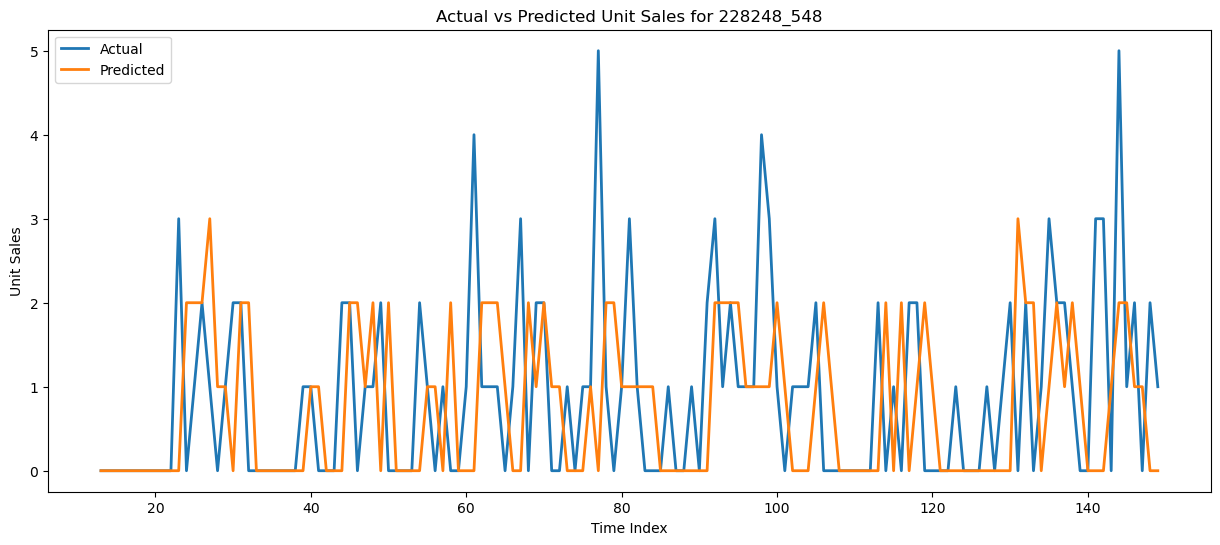

In [7]:
for unique_id in random_unique_ids:
    fig, ax = plt.subplots(figsize=(15, 6))
    
    test_data = testing_data[testing_data["unique_id"] == unique_id]
    test_predictions = test_predictions_dict[unique_id]
    
    actuals = test_data["unit_sales"].values
    actuals_range = np.arange(window_size - 1, len(actuals))
    
    ax.plot(actuals_range, actuals[window_size - 1:], label="Actual", linewidth=2)
    ax.plot(actuals_range, test_predictions, label="Predicted", linestyle="-", linewidth=2)

    ax.set_xlabel("Time Index")
    ax.set_ylabel("Unit Sales")
    ax.set_title(f"Actual vs Predicted Unit Sales for {unique_id}")
    ax.legend()

    plt.show()

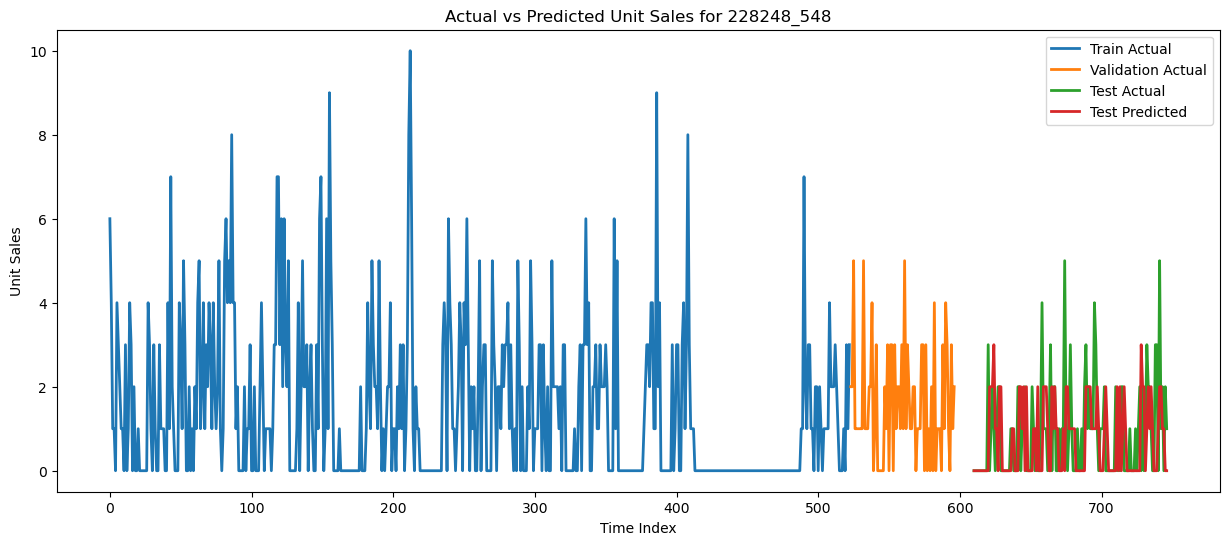

In [8]:
for unique_id in random_unique_ids:
    fig, ax = plt.subplots(figsize=(15, 6))
    
    # Training data
    train_data = training_data[training_data["unique_id"] == unique_id]
    train_actuals = train_data["unit_sales"].values
    train_actuals_range = np.arange(len(train_actuals))
    ax.plot(train_actuals_range, train_actuals, label="Train Actual", linewidth=2)

    # Validation data
    val_data = validation_data[validation_data["unique_id"] == unique_id]
    val_actuals = val_data["unit_sales"].values
    val_actuals_range = np.arange(len(train_actuals), len(train_actuals) + len(val_actuals))
    ax.plot(val_actuals_range, val_actuals, label="Validation Actual", linewidth=2)

    # Test data
    test_data = testing_data[testing_data["unique_id"] == unique_id]
    test_predictions = test_predictions_dict[unique_id]
    actuals = test_data["unit_sales"].values
    test_actuals_range = np.arange(window_size - 1, len(actuals)) + len(train_actuals) + len(val_actuals)
    ax.plot(test_actuals_range, actuals[window_size - 1:], label="Test Actual", linewidth=2)
    ax.plot(test_actuals_range, test_predictions, label="Test Predicted", linestyle="-", linewidth=2)

    ax.set_xlabel("Time Index")
    ax.set_ylabel("Unit Sales")
    ax.set_title(f"Actual vs Predicted Unit Sales for {unique_id}")
    ax.legend()

    plt.show()

# Evaluation Metrics

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

errors = []


# Calculate MASE
def mean_absolute_scaled_error(actuals, predictions, training_data):
    naive_forecast_errors = np.abs(np.diff(training_data["unit_sales"].values))
    naive_forecast_errors = np.mean(naive_forecast_errors)
    prediction_errors = np.abs(actuals - predictions)
    mase = np.mean(prediction_errors) / naive_forecast_errors
    return mase


for unique_id in random_unique_ids:
    # Compute the actuals and predictions
    test_data = testing_data[testing_data["unique_id"] == unique_id]
    actuals = test_data["unit_sales"].values[window_size - 1:]
    predictions = test_predictions_dict[unique_id]

    # Calculate MAE
    mae = mean_absolute_error(actuals, predictions)

    # Calculate MASE
    mase = mean_absolute_scaled_error(actuals, predictions, training_data[training_data["unique_id"] == unique_id])

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(actuals, predictions))

    errors.append({"unique_id": unique_id, "MAE": mae, "MASE": mase, "RMSE": rmse})

errors_df = pd.DataFrame(errors)
errors_df.to_csv('metrics_tft.csv', index=False)
errors_df

,unique_id,MAE,MASE,RMSE
0,228248_548,0.934307,0.714067,1.356251


In [10]:
import plotly.graph_objs as go

# Create a box plot for MAE
trace1 = go.Box(
    y=errors_df['MAE'],
    name="MAE",
    boxpoints='outliers',
    jitter=0.3,
    pointpos=0,
    boxmean=True
)

# Create a box plot for RMSE
trace2 = go.Box(
    y=errors_df['RMSE'],
    name="RMSE",
    boxpoints='outliers',
    jitter=0.3,
    pointpos=0,
    boxmean=True
)

# Create a box plot for MASE
trace3 = go.Box(
    y=errors_df['MASE'],
    name="MASE",
    boxpoints='outliers',
    jitter=0.3,
    pointpos=0,
    boxmean=True
)

# Create a layout for the box plots
layout = go.Layout(
    title="Evaluation Metrics",
    yaxis=dict(title="Value"),
    boxmode='group'
)

# Combine the traces and layout into a single figure
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)

# Plot the figure
fig.show()


# Interpretability

# Built-in Interpretability

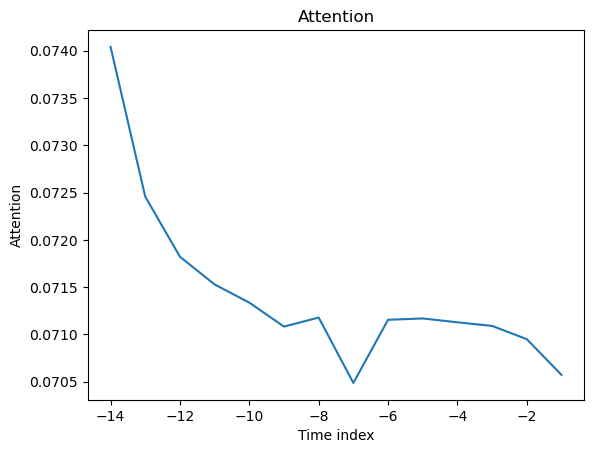

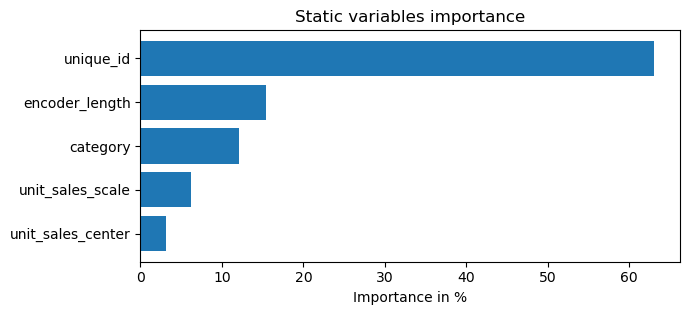

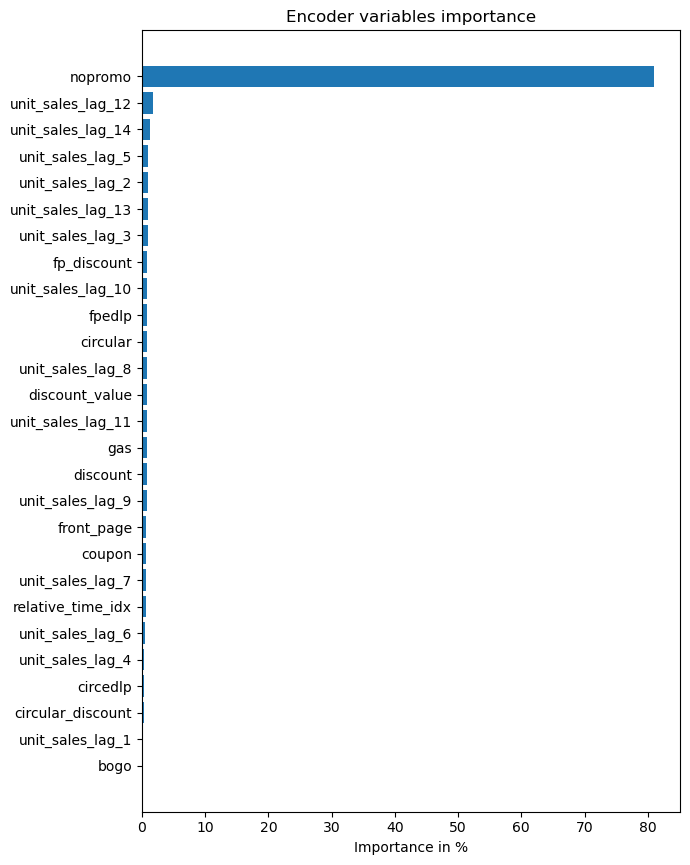

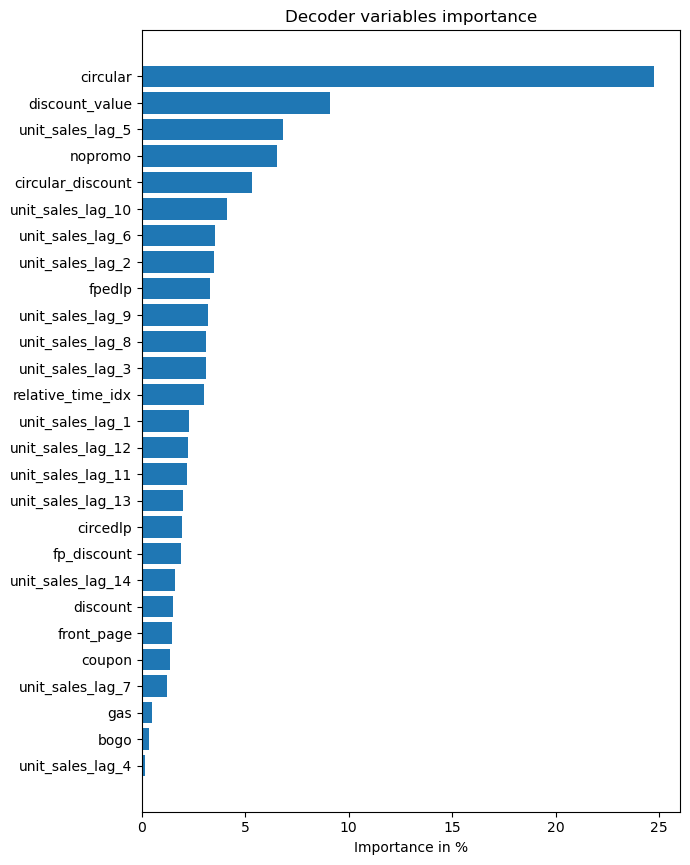

In [11]:
# feature level interpretability
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", 
                     return_x=True)
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation);